In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

оказаться прислать другой карта который мой бабушка
господин п сообщить такой случай разговор продолжиться сегодня вечером дом
пара переключать попасть результат молодой человек
надлежащий работа информирование смочь заблокировать карта снятие
смс уведомление письмо электронный почта списание дать комиссия прийти


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'господин п сообщить такой случай разговор продолжиться сегодня вечером дом'

In [7]:
for i in range(len(sample_text)):
    print(sample_text[i])

господин
п
сообщить
такой
случай
разговор
продолжиться
сегодня
вечером
дом


# Реализуйте разделение предложения на примеры методом CBOW

In [8]:
def cbow_split(tokens, window, pad_token='PAD'):
    splits = []
    tokens_len = len(tokens)
    # CODE
    
    for i in range(window, tokens_len + window):
        
        pad_tokens = [pad_token] * window + tokens + [pad_token] * window
        
        left_context = pad_tokens[i - window:i]
        center = pad_tokens[i]
        right_context = pad_tokens[i + 1:i + 1 + window]
        splits.append((left_context, center, right_context))
            
        
        
    return splits

In [9]:
splits = cbow_split(sample_text, window=2)
splits

[(['PAD', 'PAD'], 'господин', ['п', 'сообщить']),
 (['PAD', 'господин'], 'п', ['сообщить', 'такой']),
 (['господин', 'п'], 'сообщить', ['такой', 'случай']),
 (['п', 'сообщить'], 'такой', ['случай', 'разговор']),
 (['сообщить', 'такой'], 'случай', ['разговор', 'продолжиться']),
 (['такой', 'случай'], 'разговор', ['продолжиться', 'сегодня']),
 (['случай', 'разговор'], 'продолжиться', ['сегодня', 'вечером']),
 (['разговор', 'продолжиться'], 'сегодня', ['вечером', 'дом']),
 (['продолжиться', 'сегодня'], 'вечером', ['дом', 'PAD']),
 (['сегодня', 'вечером'], 'дом', ['PAD', 'PAD'])]

In [10]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: господин
Правый контекст: ['п', 'сообщить']

Левый контекст: ['PAD', 'господин']
Центральное слово: п
Правый контекст: ['сообщить', 'такой']

Левый контекст: ['господин', 'п']
Центральное слово: сообщить
Правый контекст: ['такой', 'случай']

Левый контекст: ['п', 'сообщить']
Центральное слово: такой
Правый контекст: ['случай', 'разговор']

Левый контекст: ['сообщить', 'такой']
Центральное слово: случай
Правый контекст: ['разговор', 'продолжиться']

Левый контекст: ['такой', 'случай']
Центральное слово: разговор
Правый контекст: ['продолжиться', 'сегодня']

Левый контекст: ['случай', 'разговор']
Центральное слово: продолжиться
Правый контекст: ['сегодня', 'вечером']

Левый контекст: ['разговор', 'продолжиться']
Центральное слово: сегодня
Правый контекст: ['вечером', 'дом']

Левый контекст: ['продолжиться', 'сегодня']
Центральное слово: вечером
Правый контекст: ['дом', 'PAD']

Левый контекст: ['сегодня', 'вечером']
Центральное слово: дом


In [11]:
splits

[(['PAD', 'PAD'], 'господин', ['п', 'сообщить']),
 (['PAD', 'господин'], 'п', ['сообщить', 'такой']),
 (['господин', 'п'], 'сообщить', ['такой', 'случай']),
 (['п', 'сообщить'], 'такой', ['случай', 'разговор']),
 (['сообщить', 'такой'], 'случай', ['разговор', 'продолжиться']),
 (['такой', 'случай'], 'разговор', ['продолжиться', 'сегодня']),
 (['случай', 'разговор'], 'продолжиться', ['сегодня', 'вечером']),
 (['разговор', 'продолжиться'], 'сегодня', ['вечером', 'дом']),
 (['продолжиться', 'сегодня'], 'вечером', ['дом', 'PAD']),
 (['сегодня', 'вечером'], 'дом', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [12]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'господин', ['п', 'сообщить', 'такой']),
 (['PAD', 'PAD', 'господин'], 'п', ['сообщить', 'такой', 'случай']),
 (['PAD', 'господин', 'п'], 'сообщить', ['такой', 'случай', 'разговор']),
 (['господин', 'п', 'сообщить'],
  'такой',
  ['случай', 'разговор', 'продолжиться']),
 (['п', 'сообщить', 'такой'],
  'случай',
  ['разговор', 'продолжиться', 'сегодня']),
 (['сообщить', 'такой', 'случай'],
  'разговор',
  ['продолжиться', 'сегодня', 'вечером']),
 (['такой', 'случай', 'разговор'],
  'продолжиться',
  ['сегодня', 'вечером', 'дом']),
 (['случай', 'разговор', 'продолжиться'],
  'сегодня',
  ['вечером', 'дом', 'PAD']),
 (['разговор', 'продолжиться', 'сегодня'], 'вечером', ['дом', 'PAD', 'PAD']),
 (['продолжиться', 'сегодня', 'вечером'], 'дом', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [13]:
' '.join(sample_text)

'господин п сообщить такой случай разговор продолжиться сегодня вечером дом'

# Реализуйте разделение предложения на примеры методом Skipgram

In [14]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    
    for i, center in enumerate(tokens):
        left_index = max(i - window, 0)
        right_index = min(i + window + 1, len(tokens))
        
        left_context = tokens[left_index:i] # left border
        right_context = tokens[i + 1:right_index] # right border
        
        for word in left_context + right_context:
            splits.append((word, center))
    
    return splits

In [15]:
splits = skipgram_split(sample_text, window=2)

In [16]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: п
Центральное слово: господин

Контекст: сообщить
Центральное слово: господин

Контекст: господин
Центральное слово: п

Контекст: сообщить
Центральное слово: п

Контекст: такой
Центральное слово: п

Контекст: господин
Центральное слово: сообщить

Контекст: п
Центральное слово: сообщить

Контекст: такой
Центральное слово: сообщить

Контекст: случай
Центральное слово: сообщить

Контекст: п
Центральное слово: такой

Контекст: сообщить
Центральное слово: такой

Контекст: случай
Центральное слово: такой

Контекст: разговор
Центральное слово: такой

Контекст: сообщить
Центральное слово: случай

Контекст: такой
Центральное слово: случай

Контекст: разговор
Центральное слово: случай

Контекст: продолжиться
Центральное слово: случай

Контекст: такой
Центральное слово: разговор

Контекст: случай
Центральное слово: разговор

Контекст: продолжиться
Центральное слово: разговор

Контекст: сегодня
Центральное слово: разговор

Контекст: случай
Центральное слово: продолжиться

Контекст: разго

In [17]:
skipgram_split(sample_text, window=2)

[('п', 'господин'),
 ('сообщить', 'господин'),
 ('господин', 'п'),
 ('сообщить', 'п'),
 ('такой', 'п'),
 ('господин', 'сообщить'),
 ('п', 'сообщить'),
 ('такой', 'сообщить'),
 ('случай', 'сообщить'),
 ('п', 'такой'),
 ('сообщить', 'такой'),
 ('случай', 'такой'),
 ('разговор', 'такой'),
 ('сообщить', 'случай'),
 ('такой', 'случай'),
 ('разговор', 'случай'),
 ('продолжиться', 'случай'),
 ('такой', 'разговор'),
 ('случай', 'разговор'),
 ('продолжиться', 'разговор'),
 ('сегодня', 'разговор'),
 ('случай', 'продолжиться'),
 ('разговор', 'продолжиться'),
 ('сегодня', 'продолжиться'),
 ('вечером', 'продолжиться'),
 ('разговор', 'сегодня'),
 ('продолжиться', 'сегодня'),
 ('вечером', 'сегодня'),
 ('дом', 'сегодня'),
 ('продолжиться', 'вечером'),
 ('сегодня', 'вечером'),
 ('дом', 'вечером'),
 ('сегодня', 'дом'),
 ('вечером', 'дом')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [18]:
skipgram_split(sample_text, window=3)

[('п', 'господин'),
 ('сообщить', 'господин'),
 ('такой', 'господин'),
 ('господин', 'п'),
 ('сообщить', 'п'),
 ('такой', 'п'),
 ('случай', 'п'),
 ('господин', 'сообщить'),
 ('п', 'сообщить'),
 ('такой', 'сообщить'),
 ('случай', 'сообщить'),
 ('разговор', 'сообщить'),
 ('господин', 'такой'),
 ('п', 'такой'),
 ('сообщить', 'такой'),
 ('случай', 'такой'),
 ('разговор', 'такой'),
 ('продолжиться', 'такой'),
 ('п', 'случай'),
 ('сообщить', 'случай'),
 ('такой', 'случай'),
 ('разговор', 'случай'),
 ('продолжиться', 'случай'),
 ('сегодня', 'случай'),
 ('сообщить', 'разговор'),
 ('такой', 'разговор'),
 ('случай', 'разговор'),
 ('продолжиться', 'разговор'),
 ('сегодня', 'разговор'),
 ('вечером', 'разговор'),
 ('такой', 'продолжиться'),
 ('случай', 'продолжиться'),
 ('разговор', 'продолжиться'),
 ('сегодня', 'продолжиться'),
 ('вечером', 'продолжиться'),
 ('дом', 'продолжиться'),
 ('случай', 'сегодня'),
 ('разговор', 'сегодня'),
 ('продолжиться', 'сегодня'),
 ('вечером', 'сегодня'),
 ('дом', 'с

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [19]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [20]:
len(word2index)

14999

In [21]:
word2index['UNK']

112

In [22]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[2754, 112, 112]

In [23]:
word2index

{'оказаться': 0,
 'прислать': 1,
 'другой': 2,
 'карта': 3,
 'который': 4,
 'мой': 5,
 'бабушка': 6,
 'господин': 7,
 'п': 8,
 'сообщить': 9,
 'такой': 10,
 'случай': 11,
 'разговор': 12,
 'продолжиться': 13,
 'сегодня': 14,
 'вечером': 15,
 'дом': 16,
 'пара': 17,
 'переключать': 18,
 'попасть': 19,
 'результат': 20,
 'молодой': 21,
 'человек': 22,
 'надлежащий': 23,
 'работа': 24,
 'информирование': 25,
 'смочь': 26,
 'заблокировать': 27,
 'снятие': 28,
 'смс': 29,
 'уведомление': 30,
 'письмо': 31,
 'электронный': 32,
 'почта': 33,
 'списание': 34,
 'дать': 35,
 'комиссия': 36,
 'прийти': 37,
 'звонить': 38,
 'колл': 39,
 'центр': 40,
 'думать': 41,
 'специалист': 42,
 'офис': 43,
 'таки': 44,
 'право': 45,
 'необходимый': 46,
 'работник': 47,
 'нигде': 48,
 'найти': 49,
 'скорость': 50,
 'обслуживание': 51,
 'побить': 52,
 'мыслимый': 53,
 'немыслимый': 54,
 'рекорд': 55,
 'сделать': 56,
 'я': 57,
 '##число': 58,
 'повторять': 59,
 'банк': 60,
 'кредит': 61,
 'обращаться': 62,
 'ср

# Torch Dataset
В торче есть очень удобная читалка данных

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [26]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.62359125, 0.03185465, 0.92369702, 0.37761318],
       [0.92387543, 0.62957076, 0.28477137, 0.86962337],
       [0.21890495, 0.69769149, 0.61463673, 0.99823496],
       [0.67047832, 0.04461251, 0.78400966, 0.75623563],
       [0.21126034, 0.27081006, 0.60495824, 0.93752733],
       [0.25362078, 0.37292534, 0.97707523, 0.1822313 ],
       [0.98281649, 0.62577948, 0.05524401, 0.74186917],
       [0.93169567, 0.19859561, 0.8659543 , 0.76783931],
       [0.29749765, 0.33286155, 0.49323307, 0.38185618],
       [0.33525725, 0.79314041, 0.6517785 , 0.29585602]])

In [27]:
some_data_y

array([2, 0, 1, ..., 2, 1, 1])

In [28]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [29]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [30]:
some_dataset[5], some_dataset[467]

((array([0.25362078, 0.37292534, 0.97707523, 0.1822313 ]), 2),
 (array([0.88793605, 0.66378556, 0.14869702, 0.43842975]), 1))

In [31]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [32]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.2697, 0.8396, 0.3650, 0.2801],
         [0.7289, 0.8299, 0.6001, 0.9950],
         [0.8527, 0.5007, 0.1144, 0.5321],
         [0.1362, 0.6342, 0.0459, 0.4713],
         [0.2593, 0.7958, 0.5474, 0.4839],
         [0.4034, 0.4254, 0.4901, 0.7853],
         [0.4262, 0.3869, 0.5835, 0.6766],
         [0.5222, 0.3371, 0.7001, 0.5465],
         [0.8186, 0.7062, 0.1507, 0.3390],
         [0.9667, 0.4623, 0.3199, 0.1251],
         [0.7922, 0.6710, 0.3261, 0.5181],
         [0.4977, 0.5790, 0.9460, 0.5535],
         [0.4553, 0.3963, 0.5071, 0.0454],
         [0.7988, 0.5250, 0.6979, 0.3117],
         [0.0295, 0.9481, 0.6080, 0.5104],
         [0.3766, 0.5234, 0.8580, 0.2494]], dtype=torch.float64))

In [33]:
for x, y in some_loader:
    pass

len(x)

15

In [34]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [35]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [36]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [37]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [38]:
for x, y in toy_loader:
    break

In [39]:
x.shape, y.shape

(torch.Size([128, 32]), torch.Size([128]))

In [40]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 6.2359e-01,  3.1855e-02,  9.2370e-01,  ..., -2.0679e+01,
         -4.7623e-01, -5.8433e+00],
        [ 9.2388e-01,  6.2957e-01,  2.8477e-01,  ..., -2.7763e+00,
         -7.5364e+00, -8.3817e-01],
        [ 2.1890e-01,  6.9769e-01,  6.1464e-01,  ..., -2.1599e+00,
         -2.9203e+00, -1.0600e-02],
        ...,
        [ 5.0820e-02,  2.3985e-01,  3.3988e-01,  ..., -8.5665e+00,
         -6.4750e+00, -1.9103e+00],
        [ 4.0694e-02,  4.3144e-01,  2.8902e-01,  ..., -5.0438e+00,
         -7.4475e+00, -6.3425e+00],
        [ 4.5843e-01,  9.7392e-01,  2.1245e-02,  ..., -1.5855e-01,
         -2.3110e+01, -3.3431e-01]], dtype=torch.float64)

In [41]:
y

tensor([2, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0,
        2, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 0,
        0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0,
        0, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 1, 1,
        0, 1, 2, 1, 1, 1, 1, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [42]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [43]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1850463151931763

# Боевые датасеты

In [44]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [45]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window
        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]
        self.collect_verbose = collect_verbose
        self.data = []
        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        splits = []
        
        for i, center in enumerate(tokenized_text):
            left_index = max(i - self.window, 0)
            right_index = min(i + self.window + 1, len(tokenized_text))
            
            left_context = tokenized_text[left_index:i] # left border
            right_context = tokenized_text[i + 1:right_index] # right border
        
            for word in left_context + right_context:
                splits.append((word, center))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)
            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
    
        return context, central_word

In [46]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [47]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 54240.20it/s]


In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x

tensor([  593,   112,    70,   448,   485,  1714,   706,   168,    44,    40,
           43,  2480,  4591,  6380,   112,   137,   311,  3923,   999,    35,
          424,   267,     3,   227,  1152,   205,    58,  2349,    60,   306,
         1216,  2252,   625,  1887,   154,   101,   987,   125,  9492,   464,
          455,    86,   599,   335,    75,   564,    61,  1285,  3030,   343,
          449,  1090,  1518,   112,   793,  2082,  1866,    60,  1321,     3,
        14913,   219,    29,  2306,    49,    60,   855,   446,   277,   987,
         2825,   221,   403,  1268,   375,  1130,  2825,    80,   253,  1261,
          448,  7768,   277,  2250,  1031,   449,   176,  2060,   399,   382,
          619,   101,     3,    60,    60,   435,   252,    39,   798,  1086,
         2273,    58,   963,    58,    58,  1245,   654,  2452,  2608,   957,
          277,  6770,    60,  1837,    24,    60,   508,   139,   348,   168,
           10,   515,   508,  8610,   112,  2539,   306,   508, 

In [52]:
y[:5]

tensor([2466, 2118, 2495,   58,   60])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
# CODE
class SkipGram(torch.nn.Module):

  def __init__(self, vocab_size, embedding_dim):
    
    super().__init__()
    
    self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
    
    self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
  def forward(self,x):
    x = self.in_embedding(x)
    x = self.out_embedding(x)

    return x

In [56]:
#from word2vec_utils import SkipGram

In [57]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [58]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [59]:
with torch.no_grad():
    model.to('cpu')
    pred = model(x)

pred.shape

torch.Size([512, 14999])

In [60]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [61]:
for x, y in dataset_loader:
    print(x, y)
    break
    

tensor([  769,   176,   505,  4703,   617,    60,   795,  3305,   144,  1243,
         1046,    66,    60,   448,  1700,    97,   106,   494,  2431,   222,
         2742,  2962,  3489,  3212,    24,   785,   347,  9210,  4576,    60,
         7237,  1243,    58,  1882,   800,  2078,    60,  1268,   485,   204,
           62,   881,    38,   247,   355,  4538,  2104,    85,    35,  1984,
          139,    36,   114,   112,   264,  6466,  2001,   427,    36,  1302,
          286,   663,   205,   267,    27,   335,  7475,   235,  1467,     3,
         4310,   375,   596,   602,   162,   412,  1906,    58,   420,   546,
          798,   309,   667,    29,  1160,  3558,  1740,   168,     3, 12057,
         5414,   171,    58,   691,   445,  1688,   502,  5815,  2421,    58,
          536,  7272,    75,  1807,   921,   951,  3373,   424,   278,   330,
          504,  9195,    58,   842,    60,    58,   260,    60,   588,   438,
           14,   993,   689,   778,   591,    88,   906,    57, 

# Допишите обучалку

In [62]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [63]:
model.to(device)

SkipGram(
  (in_embedding): Embedding(14999, 20)
  (out_embedding): Linear(in_features=20, out_features=14999, bias=False)
)

In [64]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), position=0, leave=True)

        for x, y in dataset_loader:
            x = x.to(device)
            y = y.to(device)
            # CODE
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2982708/2982708 [00:37<00:00, 80526.06it/s, loss=7.17]


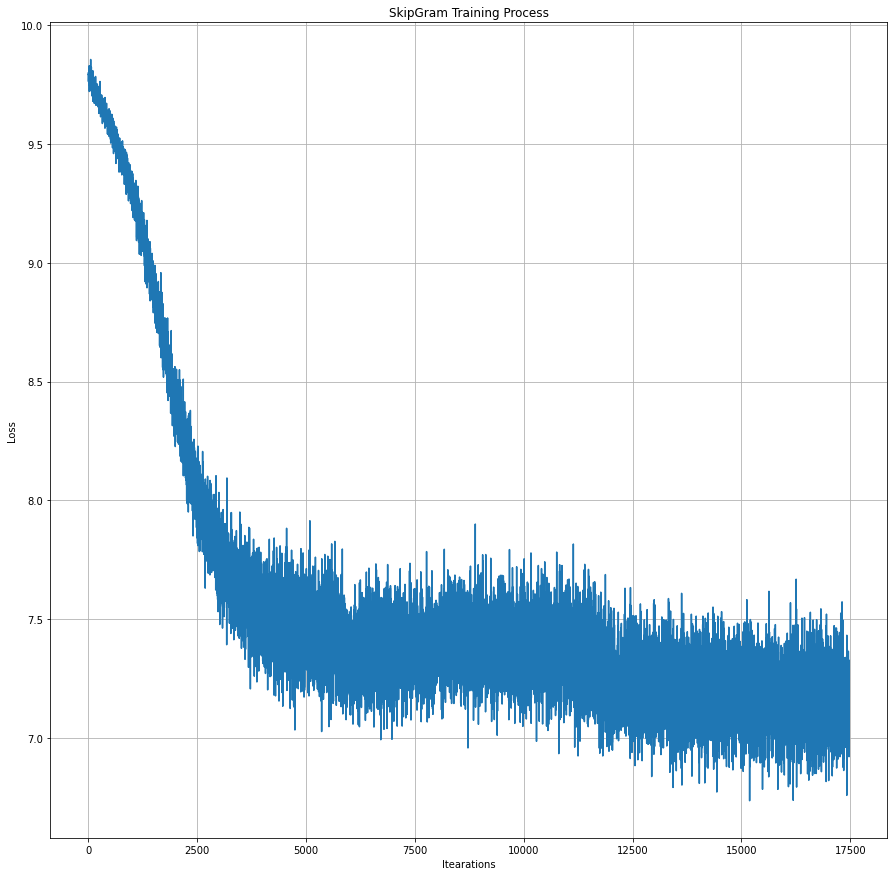

In [65]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [66]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [67]:
embedding_matrix = model.in_embedding.weight.detach()

In [68]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [69]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.43190598487854004

In [70]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.42078033089637756

In [71]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.5802775621414185

In [72]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.48229992389678955

In [73]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "благодарить" равна 0.041'

In [74]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [75]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [76]:
embedding_matrix = embedding_matrix.to('cpu')

In [77]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14999 samples in 0.001s...
[t-SNE] Computed neighbors for 14999 samples in 3.783s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14999
[t-SNE] Computed conditional probabilities for sample 2000 / 14999
[t-SNE] Computed conditional probabilities for sample 3000 / 14999
[t-SNE] Computed conditional probabilities for sample 4000 / 14999
[t-SNE] Computed conditional probabilities for sample 5000 / 14999
[t-SNE] Computed conditional probabilities for sample 6000 / 14999
[t-SNE] Computed conditional probabilities for sample 7000 / 14999
[t-SNE] Computed conditional probabilities for sample 8000 / 14999
[t-SNE] Computed conditional probabilities for sample 9000 / 14999
[t-SNE] Computed conditional probabilities for sample 10000 / 14999
[t-SNE] Computed conditional probabilities for sample 11000 / 14999
[t-SNE] Computed conditional probabilities for sample 12000 / 14999
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 98.4190216, gradient norm = 0.0000947 (50 iterations in 10.541s)
[t-SNE] Iteration 100: error = 98.4301453, gradient norm = 0.0000098 (50 iterations in 5.219s)
[t-SNE] Iteration 150: error = 98.4301300, gradient norm = 0.0000087 (50 iterations in 5.053s)
[t-SNE] Iteration 200: error = 98.4301453, gradient norm = 0.0000099 (50 iterations in 5.112s)
[t-SNE] Iteration 250: error = 98.4301300, gradient norm = 0.0000092 (50 iterations in 5.158s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.430130
[t-SNE] Iteration 300: error = 4.8739552, gradient norm = 0.0006498 (50 iterations in 6.108s)
[t-SNE] Iteration 350: error = 4.3689799, gradient norm = 0.0005864 (50 iterations in 10.078s)
[t-SNE] Iteration 400: error = 4.2403793, gradient norm = 0.0002996 (50 iterations in 7.559s)
[t-SNE] Iteration 450: error = 4.1630182, gradient norm = 0.0002100 (50 iterations in 7.224s)
[t-SNE] Iteration 500: error = 4.1064301, gradient norm = 0.0001598 (5

In [78]:
top_words = [a for a,_ in top_sorted_freq]

In [79]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

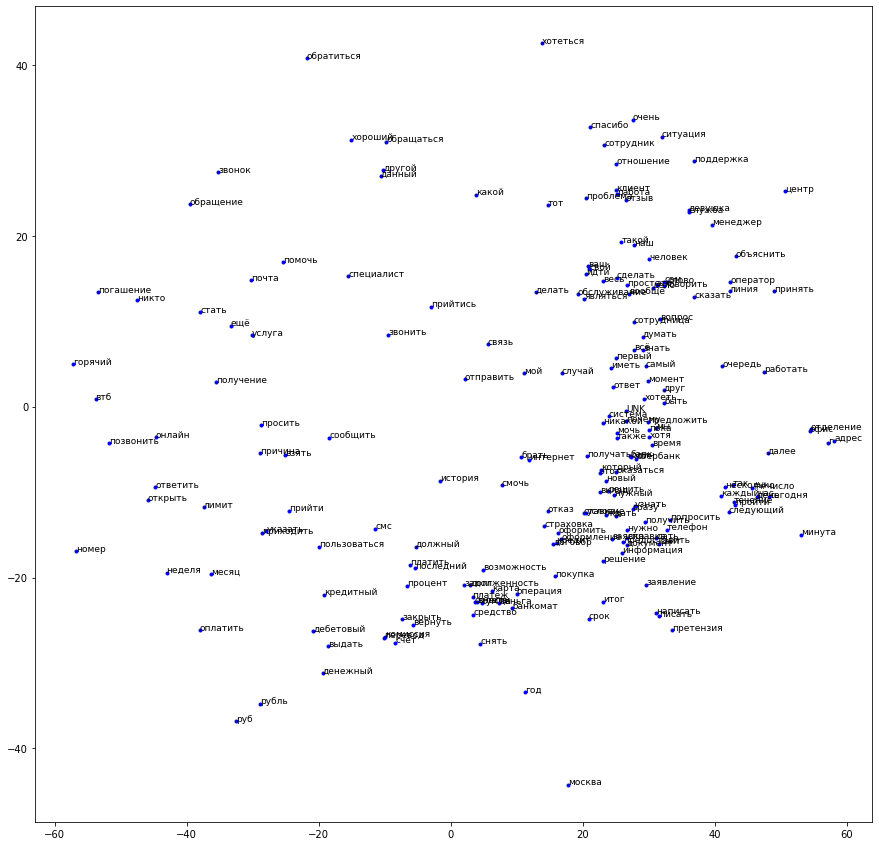

In [80]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

**Оценим модель**

In [81]:
import pandas as pd

df = pd.read_csv('ru_simlex965_tagged.tsv', delimiter='\t')
df

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23
...,...,...,...
960,яблоко_NOUN,солнце_NOUN,0.15
961,ядро_NOUN,пушка_NOUN,2.77
962,язык_NOUN,горло_NOUN,1.38
963,ярд_NOUN,дюйм_NOUN,2.62


In [82]:
df['# Word1'] = df['# Word1'].apply(lambda x: x.split('_')[0])
df['Word2'] = df['Word2'].apply(lambda x: x.split('_')[0])
df['Scaled Average Score'] = ((df['Average Score'] - df['Average Score'].min()) / (df['Average Score'].max() - df['Average Score'].min())) * 1
df


,# Word1,Word2,Average Score,Scaled Average Score
0,авария,бедствие,6.15,0.615
1,август,месяц,2.85,0.285
2,авиация,полет,6.77,0.677
3,автомобиль,гудок,1.85,0.185
4,автомобиль,автострада,1.23,0.123
...,...,...,...,...
960,яблоко,солнце,0.15,0.015
961,ядро,пушка,2.77,0.277
962,язык,горло,1.38,0.138
963,ярд,дюйм,2.62,0.262


In [83]:
df['Our Score'] = df.apply(lambda x: cos_sim(embedding_matrix, word2index, x['# Word1'], x['Word2']) 
                                        if x['# Word1'] in word2index.keys() and x['Word2'] in word2index.keys() else None, axis=1)

In [84]:
df.dropna(inplace=True)

In [85]:
df

,# Word1,Word2,Average Score,Scaled Average Score,Our Score
1,август,месяц,2.85,0.285,0.658324
3,автомобиль,гудок,1.85,0.185,0.220874
5,автомобиль,такси,4.15,0.415,0.450815
7,автомобиль,велосипед,1.38,0.138,0.019002
9,автомобиль,мост,1.15,0.115,0.361301
...,...,...,...,...,...
950,эмоция,страсть,3.85,0.385,0.233473
951,эпоха,десятилетие,4.31,0.431,0.217454
954,юг,север,0.00,0.000,0.449258
955,юрист,банкир,1.15,0.115,0.585703


In [86]:
mse = ((df['Scaled Average Score'] - df['Our Score'])**2).sum() / len(df)
mse

0.12210756062245341

**Экспериментируем**

In [87]:
from collections import defaultdict

word_freq = defaultdict(int)

for document in corpus:
    for word in document:
        word_freq[word] += 1

**Посчитаем распределение слов**

In [88]:
word_freq

defaultdict(int,
            {'оказаться': 920,
             'прислать': 567,
             'другой': 2004,
             'карта': 13322,
             'который': 5275,
             'мой': 5997,
             'бабушка': 60,
             'господин': 131,
             'п': 429,
             'сообщить': 1324,
             'такой': 3395,
             'случай': 1057,
             'разговор': 460,
             'продолжиться': 18,
             'сегодня': 1603,
             'вечером': 256,
             'дом': 454,
             'пара': 461,
             'переключать': 49,
             'попасть': 316,
             'результат': 649,
             'молодой': 193,
             'человек': 1974,
             'надлежащий': 18,
             'работа': 2406,
             'информирование': 224,
             'смочь': 994,
             'заблокировать': 803,
             'снятие': 494,
             'смс': 2389,
             'уведомление': 380,
             'письмо': 721,
             'электронный': 454,
         

**Найдём вероятность токенов по формуле word2vec**

In [89]:
total_words = sum([freq ** (3 / 4) for freq in word_freq.values()])
word_prob = {word: (freq** (3 / 4) / total_words) for word, freq in word_freq.items()}

In [90]:
np.array(list(word_prob.values())).sum()

1.0000000000001439

**Напишем функцию для negative sampling**

In [91]:
def generate_negative_sample(word_prob):
    word, context = (np.random.choice(list(word_prob.keys()), 
                     p=list(word_prob.values())) for _ in range(2))
    return word, context

word, context = generate_negative_sample(word_prob)

In [92]:
generate_negative_sample(word_prob)

('правоотношение', 'сотрудница')

In [93]:
index2word = {v: k for k, v in word2index.items()}

In [94]:
class NewSkipgramDataset(Dataset):
    
    def __init__(self, 
                corpus,
                window=5,
                word2index=word2index,
                index2word=index2word,
                word_prob = word_prob
                ):
        self.X = None
        self.y = None
        self.corpus = corpus
        self.window = window
        self.get_data(self.corpus, self.window)
        
        super().__init__()
        
        
    def __len__(self):
        return len(self.X)
    
    def get_data(self, corpus, window):
        splits = []
        neg_splits = []
        counter = 0
        for tokenized_text in corpus:
            for i, center in enumerate(tokenized_text):
                left_index = max(i - window, 0)
                right_index = min(i + window + 1, len(tokenized_text))
                
                left_context = tokenized_text[left_index:i] # left border
                right_context = tokenized_text[i + 1:right_index] # right border
            
                for word in left_context + right_context:
                    splits.append((word2index[word], word2index[center]))
        n_neg = 0
        neg_splits = []

        while n_neg < len(splits):
            (word, context) = generate_negative_sample(word_prob)
            # convert to indicies
            word, context = word2index[word], word2index[context]
            if (word, context) not in splits:
                neg_splits.append((word, context))
                n_neg += 1
                
        self.X = np.concatenate([np.array(splits), np.array(neg_splits)], axis=0)
        self.y = np.concatenate([[1]*len(splits), [0]*len(neg_splits)])
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        
        return X, y

**Грустно осознаём, что считать хотя бы 50 процентов семплов мы будем 40 часов, поэтому ограничимся оптимизацией модельки**

**Попробуем подобрать гиперпараметры**

In [100]:
dataset2 = SkipgramDataset(corpus, word2index, window=2)
dataloader2 = DataLoader(dataset2, shuffle=True, batch_size=1024)

100%|██████████| 100000/100000 [00:01<00:00, 56918.14it/s]


In [101]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=[2, 4, 5, 6], 
                                                 gamma=0.1, verbose=True)


Adjusting learning rate of group 0 to 1.0000e-02.


In [102]:
def train(model,
          optimizer,
          dataset_loader,
          scheduler,
          epochs=5):
  
  criterion = torch.nn.CrossEntropyLoss()
  losses = []

  for n_epoch in range(epochs):
    try:
      progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), position=0, leave=True)
      
      for x, y in dataset_loader:
        # CODE
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress_bar.set_postfix(loss=np.mean(losses[-100:]))
        progress_bar.update(x.shape[0])

      scheduler.step()
      progress_bar.close()
      
      
      
      
    except KeyboardInterrupt:
      progress_bar.close()
      break
    
  return losses

In [103]:
train(model, optimizer, dataloader2, scheduler, epochs=7)

Epoch 1: 100%|██████████| 2982708/2982708 [00:26<00:00, 114676.87it/s, loss=6.86]


Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2: 100%|██████████| 2982708/2982708 [00:25<00:00, 115335.54it/s, loss=6.78]


Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 3: 100%|██████████| 2982708/2982708 [00:29<00:00, 100065.25it/s, loss=6.64]


Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 4: 100%|██████████| 2982708/2982708 [00:26<00:00, 111714.53it/s, loss=6.65]


Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 5: 100%|██████████| 2982708/2982708 [00:25<00:00, 118157.84it/s, loss=6.62]


Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 6: 100%|██████████| 2982708/2982708 [00:26<00:00, 113531.96it/s, loss=6.62]


Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 7: 100%|██████████| 2982708/2982708 [00:26<00:00, 110849.16it/s, loss=6.62]

Adjusting learning rate of group 0 to 1.0000e-06.


[9.76646614074707,
 9.758198738098145,
 9.728262901306152,
 9.719436645507812,
 9.683935165405273,
 9.696295738220215,
 9.642561912536621,
 9.66306209564209,
 9.6289644241333,
 9.635459899902344,
 9.618419647216797,
 9.592147827148438,
 9.557926177978516,
 9.601914405822754,
 9.555160522460938,
 9.573623657226562,
 9.586075782775879,
 9.588303565979004,
 9.523076057434082,
 9.5033597946167,
 9.499987602233887,
 9.485189437866211,
 9.477495193481445,
 9.51375675201416,
 9.447861671447754,
 9.447685241699219,
 9.45098876953125,
 9.448307991027832,
 9.419240951538086,
 9.397380828857422,
 9.35892391204834,
 9.30130672454834,
 9.295724868774414,
 9.30051326751709,
 9.344432830810547,
 9.243884086608887,
 9.247234344482422,
 9.248991966247559,
 9.18019962310791,
 9.195488929748535,
 9.206873893737793,
 9.131580352783203,
 9.167745590209961,
 9.128290176391602,
 9.085023880004883,
 9.021796226501465,
 9.060773849487305,
 9.043225288391113,
 9.007119178771973,
 9.017158508300781,
 9.020358085

In [104]:
embedding_matrix = model.in_embedding.weight.detach()
df['Our Score2'] = df.apply(lambda x: cos_sim(embedding_matrix, word2index, x['# Word1'], x['Word2']) 
                                        if x['# Word1'] in word2index.keys() and x['Word2'] in word2index.keys() else None, axis=1)
mse = ((df['Scaled Average Score'] - df['Our Score2'])**2).sum() / len(df)
mse

0.11776007246820235

**Лосс упал значительно, целевая метрика стала немного лучше силами методов оптимизации. Я пробовал Adam, AdamW, SGD с momentum, разный lr и разные шедулеры. Также пробовал менять значения окна, и порога удаления уникальных слов в датасете, особо на скор не повлияло. Можно, конечно, поменять архитектуру модели, можно затюнить обработку корпуса и всё-таки посчитать negative sampling, но дедлайн и так был пару(4) часов назад, так что остановимся на достигнутом**

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов